In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statistics as stats
from sklearn.linear_model import LogisticRegression
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")

# original random seed = 123; for reproducibility
np.random.seed(123) 

# # alternative random seed to see if we get different results
# np.random.seed(73)  

In [2]:
# # uncomment this section if using goole colab via googledrive

# from google.colab import drive
# drive.mount('/content/drive')
# filepath = "./drive/MyDrive/Colab Notebooks/"
# csvfile = "project_residential_price_data_optional.csv"
# df = pd.read_csv(os.path.join(filepath,csvfile))
# print("Size of dataset: {}".format(len(df)))
# df.head()

In [3]:
csvfile = "project_residential_price_data_optional.csv"
df = pd.read_csv(csvfile)
print("Size of dataset: {}".format(len(df)))
df.head()

Size of dataset: 372


,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.11,V.12,...,V.23,V.24,V.25,V.26,V.27,V.28,V.29,V.9,V.10,V.30
0,1,3150.0,920.0,598.5,190,1010.84,16,1200,6713.00,56.2,...,1755.00,8003.0,67.81,63.25,3758.77,42587.00,628132.9,2200,4,0
1,1,7600.0,1140.0,3040.0,400,963.81,23,2900,3152.00,106.0,...,8842.18,8864.0,105.52,105.32,12113.01,45966.00,1188995.8,5000,3,0
2,1,4800.0,840.0,480.0,100,689.84,15,630,1627.00,41.0,...,1755.00,7773.0,45.91,38.34,1537.96,39066.00,524764.8,1200,2,1
3,1,685.0,202.0,13.7,20,459.54,4,140,2580.93,12.1,...,1612.95,1649.0,11.62,10.06,392.96,8435.75,141542.6,165,2,0
4,1,3000.0,800.0,1230.0,410,631.91,13,5000,6790.00,203.8,...,9248.40,9380.0,158.63,169.50,10082.00,49572.00,2318397.0,5500,4,1


# Objectives & Approach:
1) Predict actual prices (regression task, 'V.9')

2) Predict margin, good/bad investment (classification task, 'V.30')

Experiment Approach: we will try out basic linear regression models & then see if we can further improve it with kernel ridge regression. If none of the models provide good accuracy/R-squared/RMSE, we will then try out more sophiscated models/approaches i.e. Trees, Ensemble learning, Neural Networks. In general, we are inclined to use linear regression based methods as they are simpler and more explanable to business users.

In [4]:
categorical_cols = ['V.1', 'V.10']
df_oh = pd.get_dummies(df, prefix=categorical_cols, columns=categorical_cols)
print(df_oh.columns)
df_oh.head()

Index(['V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.11', 'V.12', 'V.13',
       'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20', 'V.21', 'V.22',
       'V.23', 'V.24', 'V.25', 'V.26', 'V.27', 'V.28', 'V.29', 'V.9', 'V.30',
       'V.1_1', 'V.1_2', 'V.10_1', 'V.10_2', 'V.10_3', 'V.10_4'],
      dtype='object')


,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.11,V.12,V.13,...,V.28,V.29,V.9,V.30,V.1_1,V.1_2,V.10_1,V.10_2,V.10_3,V.10_4
0,3150.0,920.0,598.5,190,1010.84,16,1200,6713.00,56.2,61.52,...,42587.00,628132.9,2200,0,1,0,0,0,0,1
1,7600.0,1140.0,3040.0,400,963.81,23,2900,3152.00,106.0,103.03,...,45966.00,1188995.8,5000,0,1,0,0,0,1,0
2,4800.0,840.0,480.0,100,689.84,15,630,1627.00,41.0,41.25,...,39066.00,524764.8,1200,1,1,0,0,1,0,0
3,685.0,202.0,13.7,20,459.54,4,140,2580.93,12.1,10.03,...,8435.75,141542.6,165,0,1,0,0,1,0,0
4,3000.0,800.0,1230.0,410,631.91,13,5000,6790.00,203.8,162.84,...,49572.00,2318397.0,5500,1,1,0,0,0,0,1


In [5]:
train, test = train_test_split(df_oh, test_size=0.2)
train_y1 = train['V.9']
test_y1 = test['V.9']

train_y2 = train['V.30']
test_y2 = test['V.30']

train_x = train.drop(columns=['V.9', 'V.30'])
test_x = test.drop(columns=['V.9', 'V.30'])
train_x

,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.11,V.12,V.13,...,V.26,V.27,V.28,V.29,V.1_1,V.1_2,V.10_1,V.10_2,V.10_3,V.10_4
102,1430.0,440.0,57.20,40,772.31,4,280,3321.00,31.4,33.00,...,25.62,1936.75,36818.00,415431.1,1,0,0,1,0,0
114,1800.0,560.0,36.00,20,459.54,4,110,2580.93,12.1,10.03,...,10.06,392.96,8435.75,141542.6,1,0,1,0,0,0
91,1052.0,250.0,168.32,160,948.12,6,770,7196.00,51.3,56.13,...,54.26,2978.26,41407.00,601988.1,1,0,0,1,0,0
95,1130.0,260.0,339.00,300,511.56,3,1400,5909.00,177.6,147.44,...,146.20,10149.00,24786.00,1681849.3,1,0,0,0,1,0
328,810.0,210.0,251.10,310,408.80,6,810,6458.00,224.7,198.55,...,178.30,11568.00,12732.00,2435004.3,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,15670.0,3440.0,7208.20,460,1010.50,5,3000,3629.00,137.4,125.83,...,127.33,9501.30,24130.00,1660444.0,1,0,0,0,1,0
230,960.0,220.0,67.20,70,405.89,7,140,2898.00,30.9,31.47,...,23.87,1991.43,27613.50,413834.5,0,1,0,1,0,0
98,1560.0,400.0,171.60,110,878.55,5,420,2374.00,38.0,39.43,...,33.37,1601.79,9766.50,403875.0,1,0,0,1,0,0
322,640.0,170.0,102.40,160,351.48,6,700,3629.00,137.4,125.83,...,127.33,9501.30,24130.00,1660444.0,0,1,0,0,1,0


In [6]:
# Fit and transform the input data#
# Exclude one-hot encoded columns#
cols_to_scale = train_x.columns.tolist()[:-6]
sc = StandardScaler()
train_x[cols_to_scale] = sc.fit_transform(train_x[cols_to_scale])

# Transform the scalers for x_test#
test_x[cols_to_scale] = sc.transform(test_x[cols_to_scale])

In [7]:
train_x.head()

,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.11,V.12,V.13,...,V.26,V.27,V.28,V.29,V.1_1,V.1_2,V.10_1,V.10_2,V.10_3,V.10_4
102,-0.178877,0.000357,-0.475449,-1.082238,0.844517,-1.055315,-0.814087,-0.544166,-0.999810,-1.117133,...,-1.190665,-1.104179,0.621401,-0.989220,1,0,0,1,0,0
114,0.016437,0.227713,-0.509890,-1.256735,-0.326091,-1.055315,-0.983000,-0.963883,-1.302523,-1.577373,...,-1.489085,-1.469414,-1.420726,-1.417685,1,0,1,0,0,0
91,-0.378414,-0.359623,-0.294929,-0.035252,1.502524,-0.137515,-0.327221,1.653472,-0.687687,-0.653686,...,-0.641389,-0.857774,0.951583,-0.697374,1,0,0,1,0,0
95,-0.337239,-0.340677,-0.017649,1.186231,-0.131395,-1.514215,0.298751,0.923572,1.293276,1.175854,...,1.121895,0.838708,-0.244312,0.991936,1,0,0,0,1,0
328,-0.506159,-0.435409,-0.160448,1.273480,-0.515996,-0.137515,-0.287476,1.234928,2.032019,2.199924,...,1.737529,1.174421,-1.111607,2.170155,0,1,0,0,1,0


# Start Training, 2 types of model to try out:

## Linear regression & Kernel Ridge Regression

In [8]:
# A function that infers using sklearn model class. 
# Results and metrics will be printed out.

def printALLmetrics(modelname, model, tr_x, tr_y, te_x, te_y):
    y_train_pred = model.predict(tr_x)
    y_test_pred = model.predict(te_x)
    root_mse_train = mean_squared_error(tr_y,y_train_pred)**0.5
    root_mse_test = mean_squared_error(te_y,y_test_pred)**0.5
    r_2_train = r2_score(tr_y,y_train_pred)
    r_2_test = r2_score(te_y,y_test_pred)
    
    # R^2: closer to 1.0 == linear relationship # 
    print("Performing {} on all inputs yields a R^2 score of: {:.4f} (train) and {:.4f} (test)".format(modelname,
                                                                                                     r_2_train,
                                                                                                     r_2_test))
   
    print("Root Mean Squared Error (lower is better): {:.4f} (train) and {:.4f} (test)\n".format(root_mse_train,
                                                                                               root_mse_test))
    
    testscores = (r_2_test,root_mse_test)
    
    return y_train_pred, y_test_pred, testscores

In [9]:
# Generate and save results using linear regression
results_test = []
results_train = []
test_r2_scores = []

# perform training only on the train dataset
# train:test = 9:1
lin_reg = LinearRegression().fit(train_x, train_y1) 
linreg_y_train_pred, linreg_y_test_pred, linreg_y_test_scores = printALLmetrics("Linear Regression", lin_reg, train_x, train_y1, test_x, test_y1)
results_test.append(linreg_y_test_pred)
results_train.append(linreg_y_train_pred)
test_r2_scores.append(linreg_y_test_scores)

Performing Linear Regression on all inputs yields a R^2 score of: 0.9841 (train) and 0.9689 (test)
Root Mean Squared Error (lower is better): 155.1902 (train) and 191.5989 (test)



### Next, we try out linear regression with kernel ridge regression. There are few parameters to tune for each type of kernel. To attempt to find the best model we use default parameters and vary the alpha (regularization strength) and put it through a 5-fold cross validation on the train dataset.

In [10]:
linearK_dict = {}
polyK_dict = {}
rbfK_dict = {}

# KRR Regularization strength (alpha): ranges from 0.1 to 2.0 in 0.1 increments# 
# Here we will select each model's best alpha parameters using 5-fold CV #
# We used 5 fold cross validation and store the averaged RMSE for plotting vs alpha #

for i in [(x+1) * 0.1 for x in range(20)]: 
    i = round(i,1)
    
    ## linear kernel ##
    LinearKernel = KernelRidge(alpha=i, kernel='linear')
    # CV 5folds, get rmse as score #
    scores = cross_val_score(LinearKernel, train_x, train_y1, cv=5, scoring='neg_root_mean_squared_error')
    # take average of the 5 rmse result #
    linearK_dict[i] = stats.mean(scores)

    ## polynomial kernel ##
    PolyKernel = KernelRidge(alpha=i, kernel='poly', degree=3.0)
    # CV 5folds, get rmse as score #
    scores = cross_val_score(PolyKernel, train_x, train_y1, cv=5, scoring='neg_root_mean_squared_error')
    # take average of the 5 rmse result #
    polyK_dict[i] = stats.mean(scores)
    
    ## rbf kernel ##
    RBFKernel = KernelRidge(alpha=i, kernel='rbf')
    # CV 5folds, get rmse as score#
    scores = cross_val_score(RBFKernel, train_x, train_y1, cv=5, scoring='neg_root_mean_squared_error')
    # take average of the 5 rmse result #
    rbfK_dict[i] = stats.mean(scores)

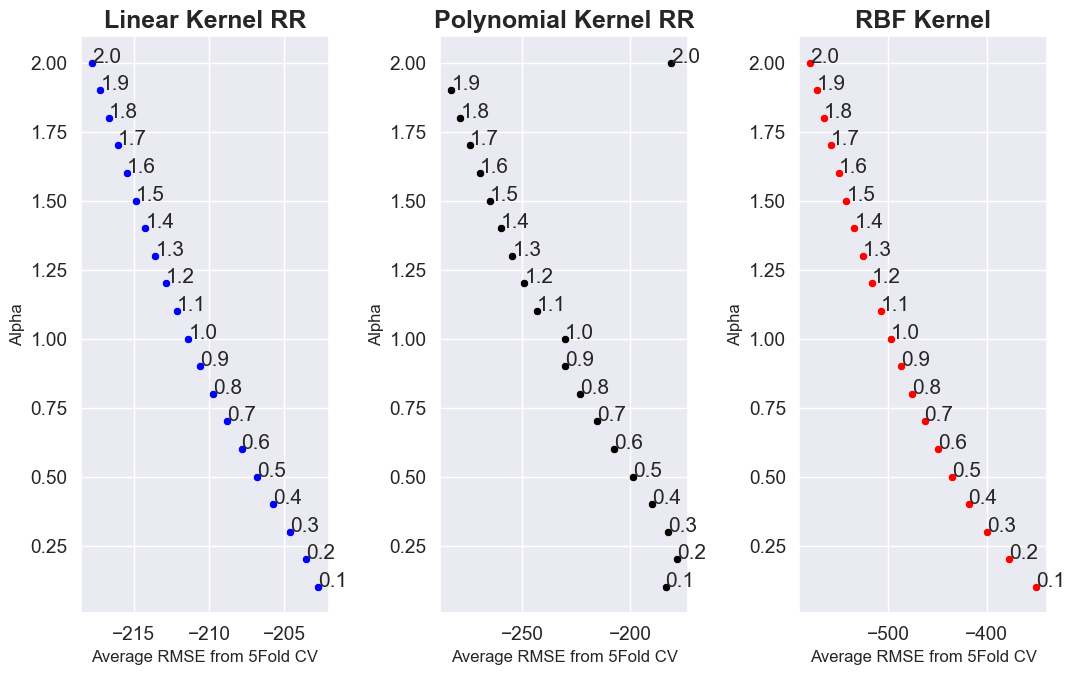

In [34]:
# Plot all results #
fig2, axes = plt.subplots(1, 3, figsize=(11, 7))
results_title = ["Linear Kernel RR", "Polynomial Kernel RR", "RBF Kernel"]

for idx, i in enumerate([(x+1) * 0.1 for x in range(20)]): 
    i = round(i,1)
    linK = linearK_dict.get(i)
    polyK = polyK_dict.get(i)
    rbfK = rbfK_dict.get(i)
    sns.scatterplot(x=[linK],y=[i], ax=axes[0],color='blue')
    axes[0].text(x=linK, y=i, s=str(i))
    sns.scatterplot(x=[polyK],y=[i], ax=axes[1],color='black')
    axes[1].text(x=polyK, y=i, s=str(i))
    sns.scatterplot(x=[rbfK],y=[i], ax=axes[2],color='red')
    axes[2].text(x=rbfK, y=i, s=str(i))

for idx in range(3):
    axes[idx].set_ylabel("Alpha",fontsize=12)
    axes[idx].set_xlabel("Average RMSE from 5Fold CV",fontsize=12)
    axes[idx].set_title(results_title[idx], fontweight="bold", size=18)

fig2.tight_layout()

## Seems like all models perform better with less regularization strength. Polynomial Kernel Ridge Regression gave the lowest RMSE (~178) 

## So we will set alpha to be 0.2 and re-train the model using Polynomial Kernel Ridge Regression with varying polynomial degrees.

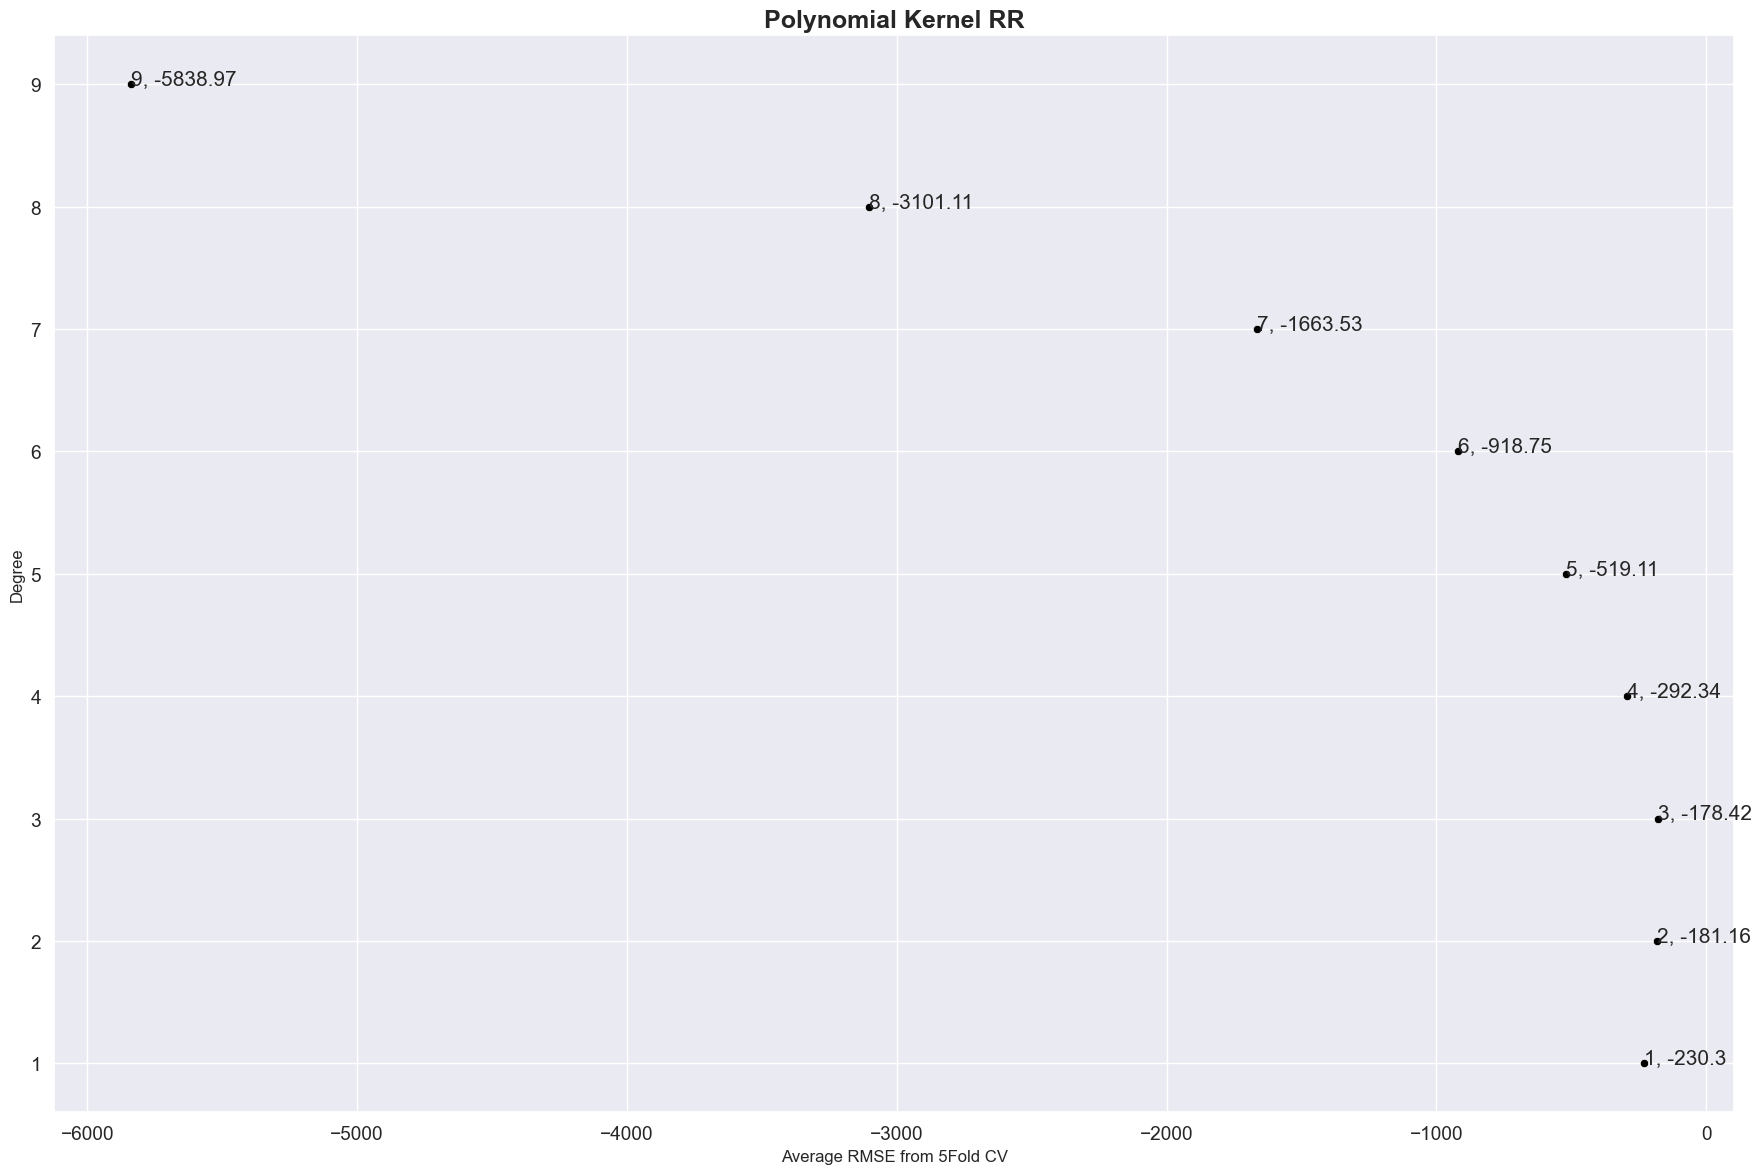

In [12]:
# Re-trained with "optimised" alpha values and then plot results #
polyK_dict[i] = {}
for i in range(1, 10):
    PolyKernel = KernelRidge(alpha=0.2, kernel='poly', degree=i)
    # CV 5folds, get rmse as score #
    scores = cross_val_score(PolyKernel, train_x, train_y1, cv=5, scoring='neg_root_mean_squared_error')
    # take average of the 5 rmse result #
    polyK_dict[i] = stats.mean(scores)

# Plot all results #
fig2, axes = plt.subplots(1, 1, figsize=(18, 12))
results_title = ["Polynomial Kernel RR"]
for idx, i in enumerate(range(1, 10)): 
    polyK = polyK_dict.get(i)
    sns.scatterplot(x=[polyK],y=[i], ax=axes,color='black')
    axes.text(x=polyK, y=i, s=str(i)+", "+ str(round(polyK,2)))

for idx in range(1):
    axes.set_ylabel("Degree",fontsize=12)
    axes.set_xlabel("Average RMSE from 5Fold CV",fontsize=12)
    axes.set_title(results_title[idx], fontweight="bold", size=18)

fig2.tight_layout()

## Based on 5-fold cross validations, we find that a Polynomial Kernel Ridge Regression with alpha of 0.2 & degree of 3.0 is the most suitable model for Kernel Ridge regression. 

## Next, we train on the full training dataset using both Linear Regression and Kernel Ridge Regression.

In [13]:
PolyKernel = KernelRidge(alpha=0.2, kernel='poly', degree=3.0)
PolyKernel.fit(train_x, train_y1)
polykernel_y_train_pred, polykernel_y_test_pred, testscores = printALLmetrics("Polynomial Kernel", 
                                                                              PolyKernel, 
                                                                              train_x, train_y1, test_x, test_y1)
results_test.append(polykernel_y_test_pred)
results_train.append(polykernel_y_train_pred)
test_r2_scores.append(testscores)

Performing Polynomial Kernel on all inputs yields a R^2 score of: 0.9986 (train) and 0.9887 (test)
Root Mean Squared Error (lower is better): 45.4275 (train) and 115.4908 (test)



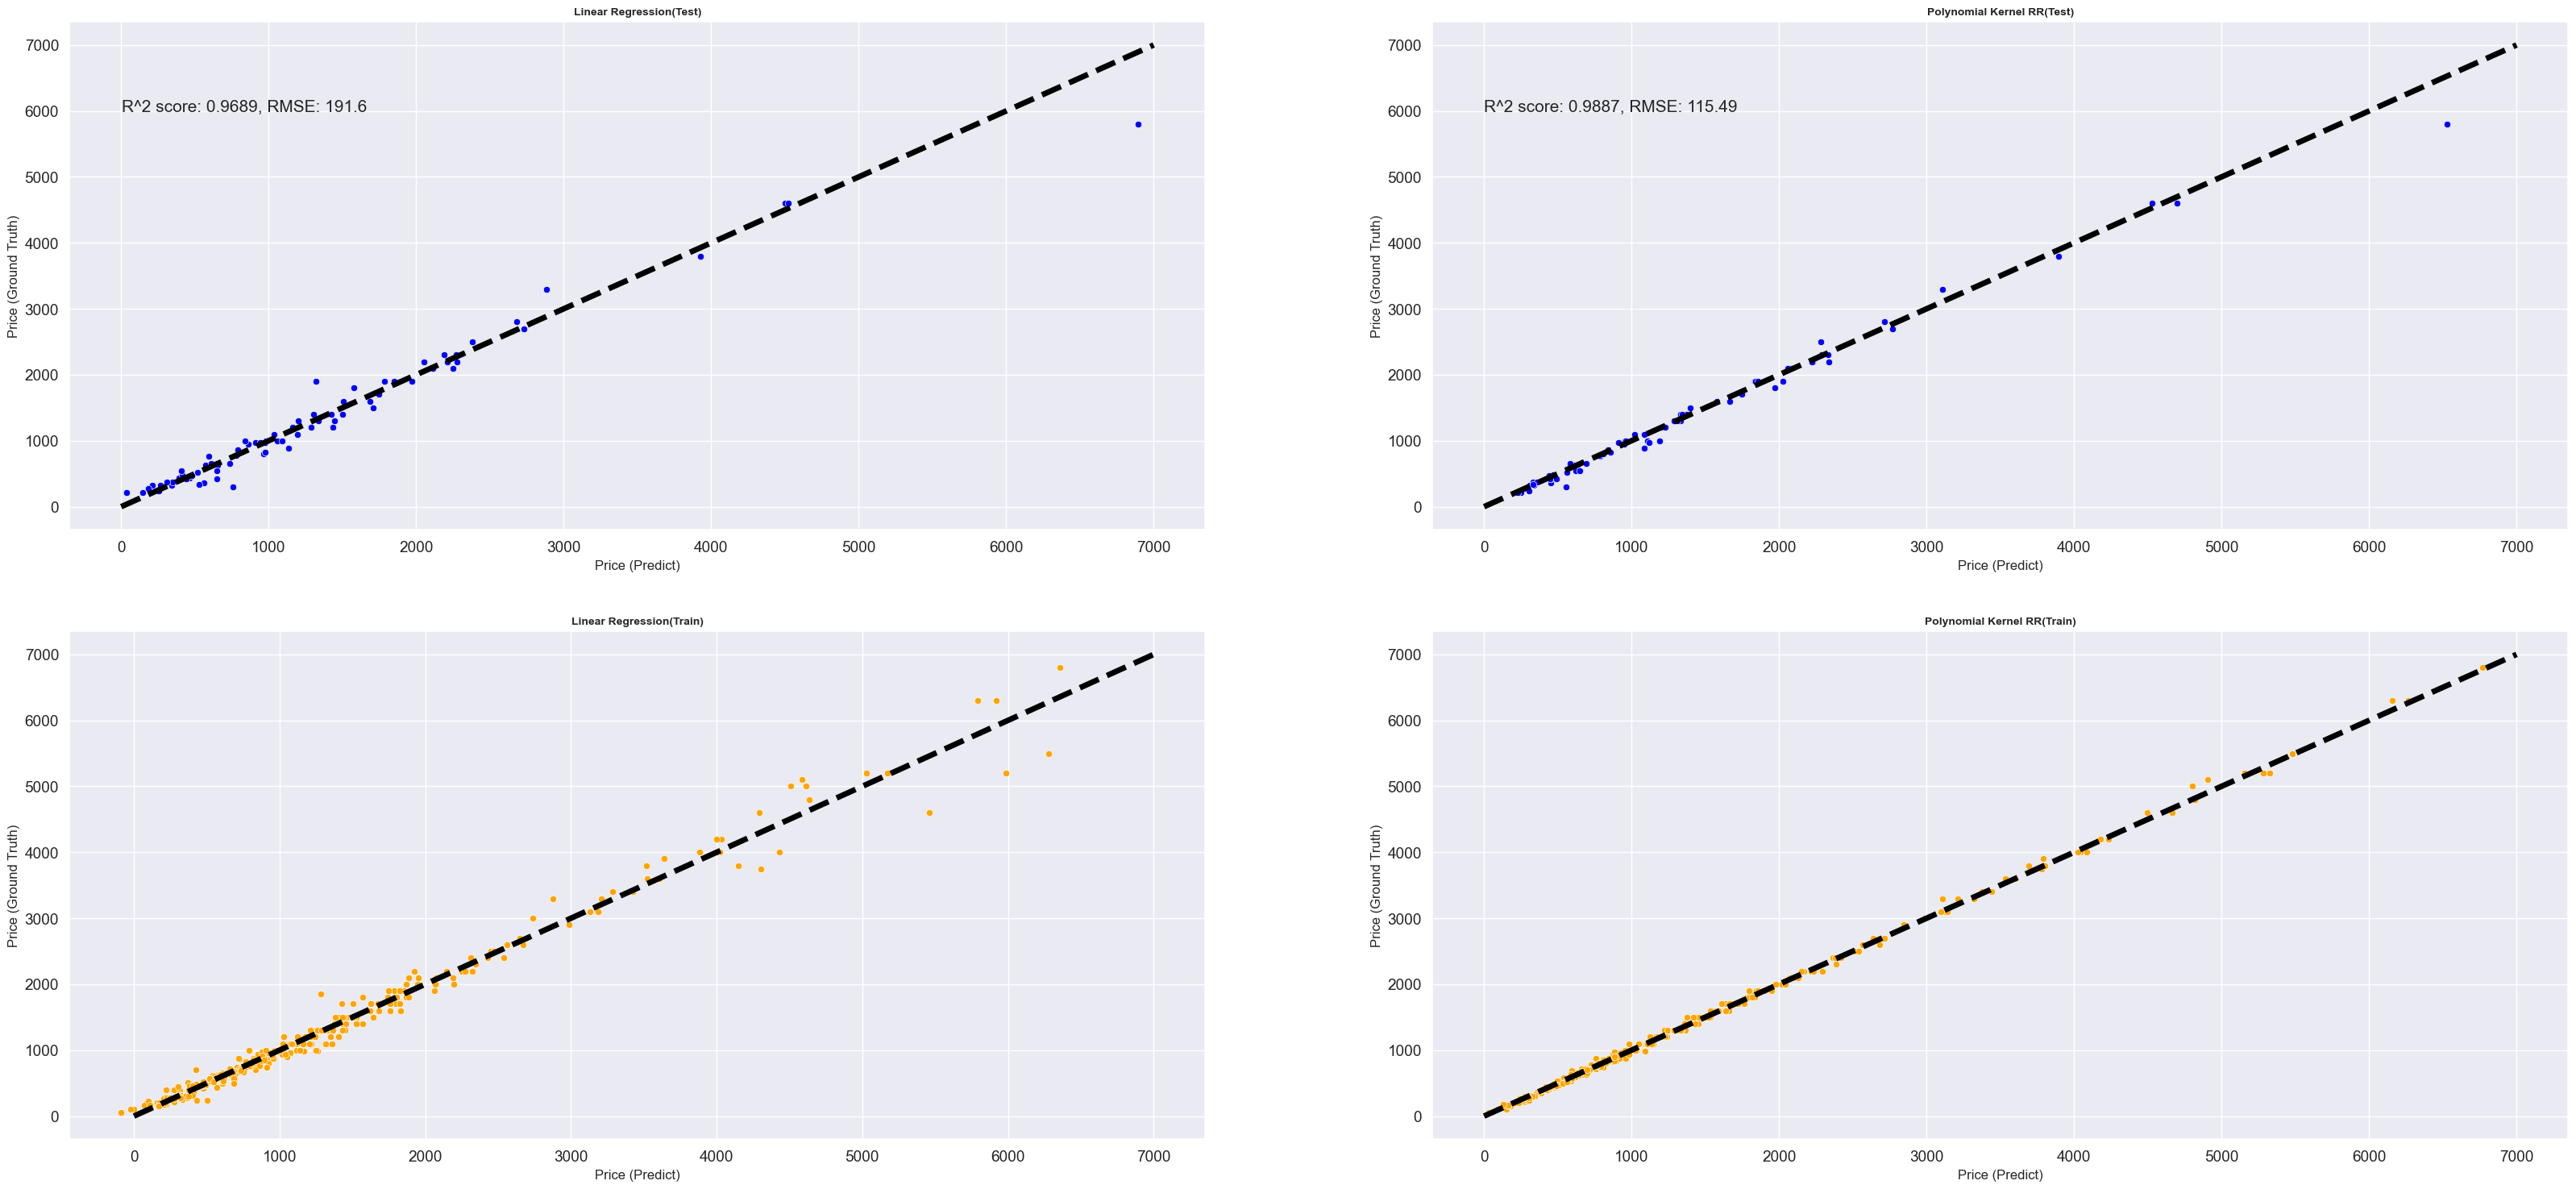

In [14]:
# Plot all results #
fig2, axes = plt.subplots(2, 2, figsize=(40, 18))
results_title = ["Linear Regression", "Polynomial Kernel RR"]
for idx, i in enumerate(results_test):
    sns.scatterplot(x=i,y=test_y1, ax=axes[0,idx],color='blue')
    axes[0,idx].plot([0,.7e4],[0,.7e4],'k--', linewidth=5)
    axes[0,idx].set_title(results_title[idx]+"(Test)", fontweight="bold", size=10)
    axes[0,idx].set_xlabel("Price (Predict)",fontsize=12)
    axes[0,idx].set_ylabel("Price (Ground Truth)",fontsize=12)
    axes[0,idx].text(x=1, y=6000, s="R^2 score: "+ str(round(test_r2_scores[idx][0],4))+", "+\
                                      "RMSE: "+str(round(test_r2_scores[idx][1],2)))

for idx, i in enumerate(results_train):
    sns.scatterplot(x=i,y=train_y1, ax=axes[1,idx],color='orange')
    axes[1,idx].set_title(results_title[idx]+"(Train)", fontweight="bold", size=10)
    axes[1,idx].plot([0,.7e4],[0,.7e4],'k--', linewidth=5)
    axes[1,idx].set_xlabel("Price (Predict)",fontsize=12)
    axes[1,idx].set_ylabel("Price (Ground Truth)",fontsize=12)

In [15]:
df.describe()['V.9']

count     372.000000
mean     1387.432796
std      1206.083047
min        50.000000
25%       577.500000
50%      1000.000000
75%      1700.000000
max      6800.000000
Name: V.9, dtype: float64

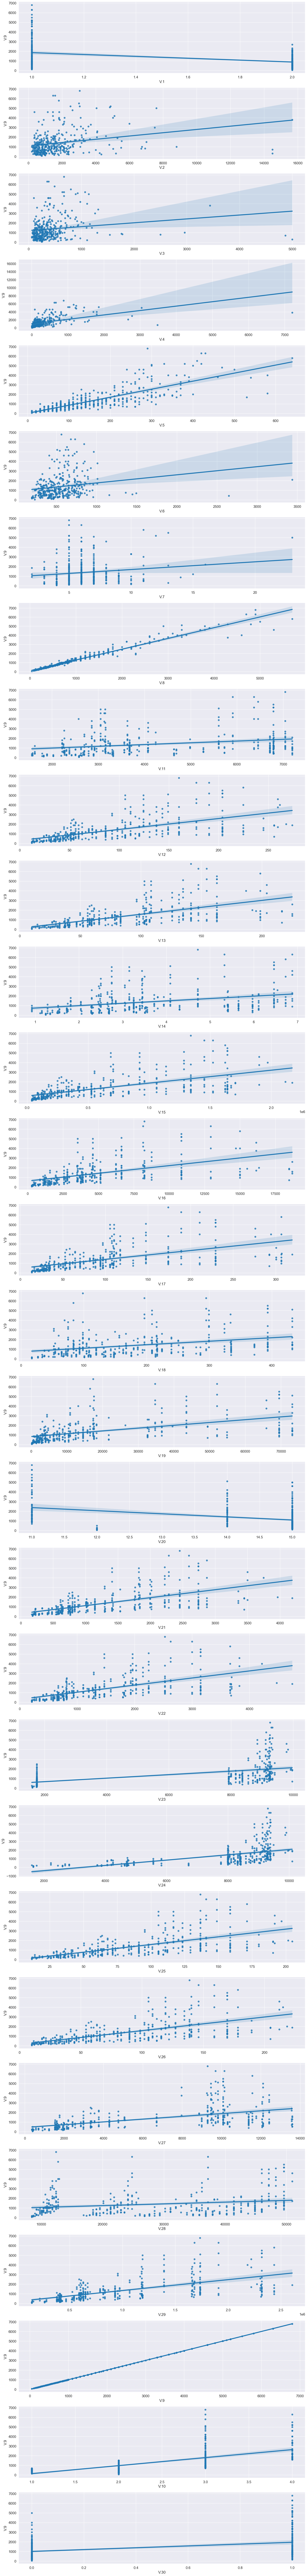

In [16]:
fig2, axes = plt.subplots(len(df.columns), 1, figsize=(20, 180))
df = pd.read_csv(csvfile)
# # use the following if running from colab on googledrive
# df = pd.read_csv(os.path.join(filepath,csvfile))
# map_dict = {1: "High", 0:"Low"}
# df["V.30"] = df["V.30"].map(map_dict)
for idx, col in enumerate(df.columns):
    sns.regplot(data=df, x=col,y='V.9', ax=axes[idx])        

## Taking linear regression as the baseline, the R^2 score has improved from R^2 score of 0.9689 to 0.9889 under the selected Polynomial Ridge Regression model.

## Similarly, RMSE has improved by ~40% going from 191 to 115. Given that the mean and standard deviation of housing prices are in the 1250 ballpark range. A RMSE of 115 (<10% of both mean and std-dev) is acceptable.

# Next we will try to predict whether a project is high margin or not

## Our focus in this section is feature engineering as it has implications and valuable insights for our business user.

## First, let see which column (ignore V.1 and V.10 as they are categorical) have distinct distribution over V.30 (i.e low overlaps in boxplots)

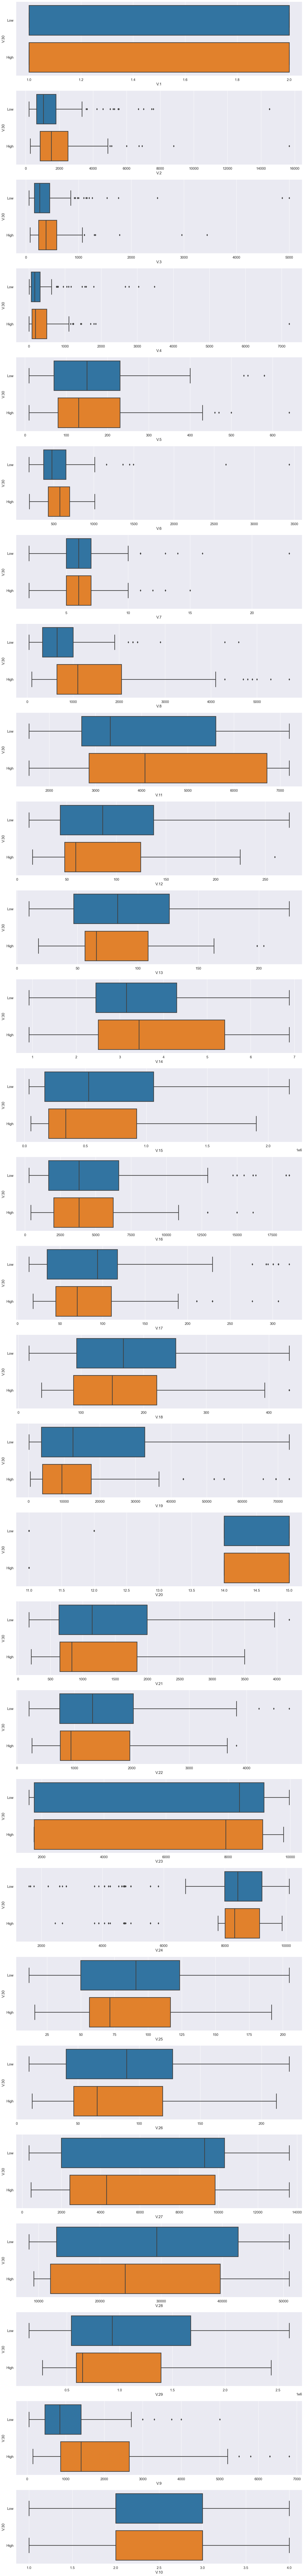

In [17]:
fig2, axes = plt.subplots(len(df.columns)-1, 1, figsize=(20, 180))
df = pd.read_csv(csvfile)
# # use the following if running from colab on googledrive
# df = pd.read_csv(os.path.join(filepath,csvfile))
map_dict = {1: "High", 0:"Low"}
df["V.30"] = df["V.30"].map(map_dict)
for idx, col in enumerate(df.columns):
    if not col in ['V.30']:
        sns.boxplot(data=df, x=col,y='V.30', ax=axes[idx])

## Looking at the box plots, we see that some features have very similar distributions regardless of whether the margin of the project is high or low. 

## Visually, if a feature's boxplot distribution is very dissimilar, it should be easier to use it to construct a decision line to classify the project's margin.

In [18]:
df['V.30'].describe() #151 high, 221 low, slightly unbalanced dataset# 

count     372
unique      2
top       Low
freq      221
Name: V.30, dtype: object

In [19]:
high_df = df.where(df['V.30']=='High').dropna()
low_df = df.where(df['V.30']=='Low').dropna()

## To come up with a quantitative measure, we had an idea to compute Jacaard Index using the IQR of each feature vs V.30. We then ranked the features in ascending order as lower Jacaard scores represents higher dissimilarity.

## In addition, having a ranked list features helps our business priortise the data to collect to evaluate a project's margin.

In [20]:
import json

def calcJacaard(rng1,rng2):
    # F ind range intersection #
    # Returns intersection over union #
    val1 = max(rng1) - min(rng2)
    val2 = max(rng2) - min(rng1)
    if val1>val2:
        return val2/val1
    else:
        return val1/val2

# Adapted from: https://www.folkstalk.com/tech/remove-outliers-in-dataframe-with-code-examples/#
def remove_outlier(df_in, col_name):
    # Remove outliers, returns q1 q3 #
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out[col_name].quantile(0.25), df_out[col_name].quantile(0.75)

JacaardResults = {}
for col in df.columns:
    if not col in ['V.30', 'V.1', 'V.10']:
        iqr_hi25, iqr_hi75 = remove_outlier(high_df, col)
        iqr_lo25, iqr_lo75 = remove_outlier(low_df, col)
        rng_hi = [iqr_hi25,iqr_hi75]
        rng_lo = [iqr_lo25,iqr_lo75]
        ratio_of_overlap = calcJacaard(rng_hi,rng_lo)
        JacaardResults[col] = ratio_of_overlap

JacaardResults = sorted(JacaardResults.items(), key=lambda x:x[1])
print("Features ranked by dissimilarity:", *JacaardResults, sep = "\n")

# # to show only the top 10 features by dissimilarity
# print()
# print("Top 10 features ranked by dissimilarity:", *JacaardResults[:10], sep = "\n")

Features ranked by dissimilarity:
('V.9', 0.22506393861892582)
('V.8', 0.24829931972789115)
('V.19', 0.3004327384950223)
('V.2', 0.4377745241581259)
('V.3', 0.4697986577181208)
('V.4', 0.5181484942140445)
('V.14', 0.6084745762711864)
('V.6', 0.6474393448164595)
('V.11', 0.6845252927984052)
('V.24', 0.6936370777690495)
('V.18', 0.7453602825155909)
('V.29', 0.7851898097243708)
('V.28', 0.8719096763674901)
('V.16', 0.8727910238429172)
('V.15', 0.8760840601801542)
('V.13', 0.8820659971305598)
('V.21', 0.8947134277452361)
('V.5', 0.9032258064516129)
('V.12', 0.9040178571428571)
('V.17', 0.9461591220850478)
('V.22', 0.9715013720109762)
('V.26', 0.9751483679525224)
('V.27', 0.9936216898080287)
('V.25', 0.9946268656716418)
('V.23', 0.9946693049822535)
('V.7', 1.0)
('V.20', nan)


/var/folders/_c/sdnjbh3j2k32jff8ry29g28w0000gn/T/ipykernel_5265/1082782166.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return val1/val2


## The price factors V.8 & V.9 has the lowest Jacaard index as evident from their boxplots (low intersection and wide overall range)

## Next we will vary the number of input features and train logistic regression models and then evaluate its performance.

## For a baseline, we train a model that uses all the available input features. Then, we remove all features and add one-by-one Top K features ranked by dissimilarity and train the models. Categorical features are added in by default for all the trained models.

## For model evaluation, we did 5-fold cross validations on the training data, followed by the model's accuracy on a fixed test dataset.

In [21]:
# Remake train dataset to include back V.9 for V.30 prediction #
train_x = train.drop(columns=['V.30'])
test_x = test.drop(columns=['V.30'])

# Fit and transform the input data # 
# Exclude one-hot encoded columns #
cols_to_scale = train_x.columns.tolist()[:-6]
sc = StandardScaler()
train_x[cols_to_scale] = sc.fit_transform(train_x[cols_to_scale])
# Transform the scalers for x_test #
test_x[cols_to_scale] = sc.transform(test_x[cols_to_scale])
oh_cols = train_x.columns.tolist()[-6:]

# Baseline #
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, train_x, train_y2, cv=5, scoring='neg_root_mean_squared_error')
score = round(abs(stats.mean(scores)),4)
clf = log_reg.fit(train_x, train_y2)
print("Baseline, selected all features, test accuracy: " + str(round(clf.score(test_x, test_y2),4)),", 5-fold CV_RMSE_Score:"  + str(score))

# Add top K features to train models #
for i in range(1,len(JacaardResults)+1):
    selected_cols = []
    log_reg = LogisticRegression()
    for item in JacaardResults[:i]:
        selected_cols.append(item[0])
    train_x_Selected = train_x[selected_cols+oh_cols]
    test_x_Selected = test_x[selected_cols+oh_cols]
    scores = cross_val_score(log_reg, train_x_Selected, train_y2, cv=5, scoring='neg_root_mean_squared_error')
    score = round(abs(stats.mean(scores)),4)
    clf = log_reg.fit(train_x_Selected, train_y2)
    print("Top: "+ str(i) + " features + categorical features, Last added feature: " + selected_cols[-1] + ", test accuracy: "\
        + str(round(clf.score(test_x_Selected, test_y2),4)), ", 5-fold CV_RMSE_Score:"  + str(score))

Baseline, selected all features, test accuracy: 0.9467 , 5-fold CV_RMSE_Score:0.3732
Top: 1 features + categorical features, Last added feature: V.9, test accuracy: 0.7067 , 5-fold CV_RMSE_Score:0.5852
Top: 2 features + categorical features, Last added feature: V.8, test accuracy: 0.7067 , 5-fold CV_RMSE_Score:0.5782
Top: 3 features + categorical features, Last added feature: V.19, test accuracy: 0.7467 , 5-fold CV_RMSE_Score:0.5677
Top: 4 features + categorical features, Last added feature: V.2, test accuracy: 0.76 , 5-fold CV_RMSE_Score:0.58
Top: 5 features + categorical features, Last added feature: V.3, test accuracy: 0.76 , 5-fold CV_RMSE_Score:0.5708
Top: 6 features + categorical features, Last added feature: V.4, test accuracy: 0.72 , 5-fold CV_RMSE_Score:0.5135
Top: 7 features + categorical features, Last added feature: V.14, test accuracy: 0.72 , 5-fold CV_RMSE_Score:0.5172
Top: 8 features + categorical features, Last added feature: V.6, test accuracy: 0.7733 , 5-fold CV_RMSE_

## It seems that we only needed the top 18 dissimilar features + categorical features to get similar test accuracy (94.6%) & a better model (lower CV score) as compared to the baseline model. However, from the top 18 features + the next 8 features there is no notable improvement in the model until we add 'V.7'.

## Evidently, adding that 8 features did not improve test accuracy but it hurts our 5-fold CV average score. So we carefully select these 18 features + 'V.7' and got 96% test accuracy and an even lower 5-fold CV score of 0.3551:

Top: 18 features + V.7 + categorical features, test accuracy: 0.96 , 5-fold CV_RMSE_Score:0.3551


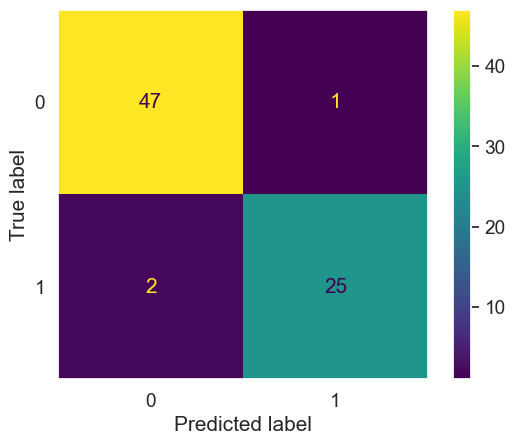

In [22]:
selected_cols = []
log_reg = LogisticRegression()
for item in JacaardResults[:(17+1)]:
    selected_cols.append(item[0])

# Add V.7 #
selected_cols.append('V.7')

train_x_Selected = train_x[selected_cols+oh_cols]
test_x_Selected = test_x[selected_cols+oh_cols]
scores = cross_val_score(log_reg, train_x_Selected, train_y2, cv=5, scoring='neg_root_mean_squared_error')
score = round(abs(stats.mean(scores)),4)
clf = log_reg.fit(train_x_Selected, train_y2)
print("Top: "+ str(18) + " features + " + selected_cols[-1] + " + categorical features, test accuracy: "\
      + str(round(clf.score(test_x_Selected, test_y2),4)), ", 5-fold CV_RMSE_Score:"  + str(score))
pred_y2 = clf.predict(test_x_Selected)
cm = confusion_matrix(test_y2, pred_y2, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
# add the following line to remove gridlines
plt.grid(False)

## One of our initial approach was to brute-force to find the best set of features to yield the best accuracy. This was done by permuting all possible sets of 1,2,3,4....27 features + categorical features to train on. Due to the large computation time, we gave up at the 27 Choose 6 mark. 

## However, one set of 6 features gave a test accuracy of 100%. 

In [23]:
# # This cell has been commented to prevent accidental execution; this cell takes a long time to run
# import time
# import itertools
# start_time = time.time()
# res_dict = {}
# for i in range(1,9):
#     selected_cols = []
#     print(res_dict)
#     end_time = time.time()
#     duration = (end_time-start_time)/60
#     print(f'time taken = {duration:.2f} min', '\n')
#     res_dict[i] = [0.0, []]
#     for subset in itertools.combinations(cols_to_scale, i):
#         selected_cols= list(subset)
#         train_x_Selected = train_x[selected_cols+oh_cols]
#         test_x_Selected = test_x[selected_cols+oh_cols]
#         clf = log_reg.fit(train_x_Selected, train_y2)
#         res = round(clf.score(test_x_Selected, test_y2),4)*100
#         if res>res_dict[i][0]:
#             res_dict[i] = [res, selected_cols]

{}
time taken = 0.00 min 

{1: [77.33, ['V.11']]}
time taken = 0.00 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']]}
time taken = 0.01 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']], 3: [94.67, ['V.5', 'V.8', 'V.17']]}
time taken = 0.12 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']], 3: [94.67, ['V.5', 'V.8', 'V.17']], 4: [98.67, ['V.5', 'V.8', 'V.23', 'V.24']]}
time taken = 0.85 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']], 3: [94.67, ['V.5', 'V.8', 'V.17']], 4: [98.67, ['V.5', 'V.8', 'V.23', 'V.24']], 5: [98.67, ['V.2', 'V.5', 'V.8', 'V.23', 'V.24']]}
time taken = 5.39 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']], 3: [94.67, ['V.5', 'V.8', 'V.17']], 4: [98.67, ['V.5', 'V.8', 'V.23', 'V.24']], 5: [98.67, ['V.2', 'V.5', 'V.8', 'V.23', 'V.24']], 6: [100.0, ['V.5', 'V.7', 'V.8', 'V.23', 'V.24', 'V.28']]}
time taken = 27.75 min 

{1: [77.33, ['V.11']], 2: [93.33, ['V.5', 'V.8']], 3: [94.67, ['V.5', 'V.8', 'V.17']], 4: [98.67, ['V.5', 'V.8', 

## We then tried to evaluate this set of features with 5-fold cross-validation on the training dataset

In [24]:
# # random seed = 73 gave the following 
# {1: [74.67, ['V.27']], 
#  2: [85.33, ['V.5', 'V.8']], 
#  3: [88.00, ['V.5', 'V.8', 'V.24']], 
#  4: [88.00, ['V.2', 'V.5', 'V.8', 'V.24']], 
#  5: [89.33, ['V.2', 'V.5', 'V.8', 'V.23', 'V.24']], 
#  6: [89.33, ['V.2', 'V.3', 'V.5', 'V.8', 'V.24', 'V.9']], 
#  7: [90.67, ['V.2', 'V.5', 'V.8', 'V.11', 'V.14', 'V.24', 'V.27']], 
#  8: [92.00, ['V.4', 'V.5', 'V.6', 'V.8', 'V.15', 'V.19', 'V.23', 'V.25']]}
# time taken = 292.34 min 

random seed = 123
variables used as predictors:
['V.5', 'V.7', 'V.8', 'V.23', 'V.24', 'V.28'] and ['V.1', 'V.10']
test accuracy: 1.0 , 5-fold CV_RMSE_Score:0.3768


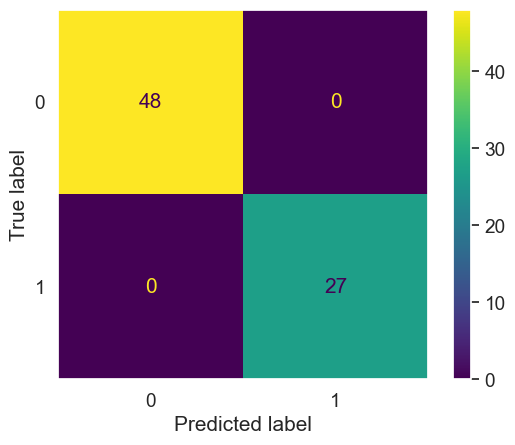

In [33]:
selected_cols = ['V.5','V.7','V.8','V.23','V.24','V.28']
    ## project variables
    # V-5	Preliminary estimated construction cost based on the prices at the beginning of the project
    # V-7	Duration of construction
    # V-8	Price of the unit at the beginning of the project per m2
    ## economic variables
    # V-23	Official exchange rate with respect to dollars 
    # V-24	Nonofficial (street market) exchange rate with respect to dollars
    # V-28	Population of the city
log_reg = LogisticRegression()
train_x_Selected = train_x[selected_cols+oh_cols]
test_x_Selected = test_x[selected_cols+oh_cols]
scores = cross_val_score(log_reg, train_x_Selected, train_y2, cv=5, scoring='neg_root_mean_squared_error')
score = round(abs(stats.mean(scores)),4)
clf = log_reg.fit(train_x_Selected, train_y2)
print("random seed = 123")
print("variables used as predictors:")
print(selected_cols, "and ['V.1', 'V.10']")
print("test accuracy: "\
      + str(round(clf.score(test_x_Selected, test_y2),4)), ", 5-fold CV_RMSE_Score:"  + str(score))
pred_y2 = clf.predict(test_x_Selected)
cm = confusion_matrix(test_y2, pred_y2, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(False)

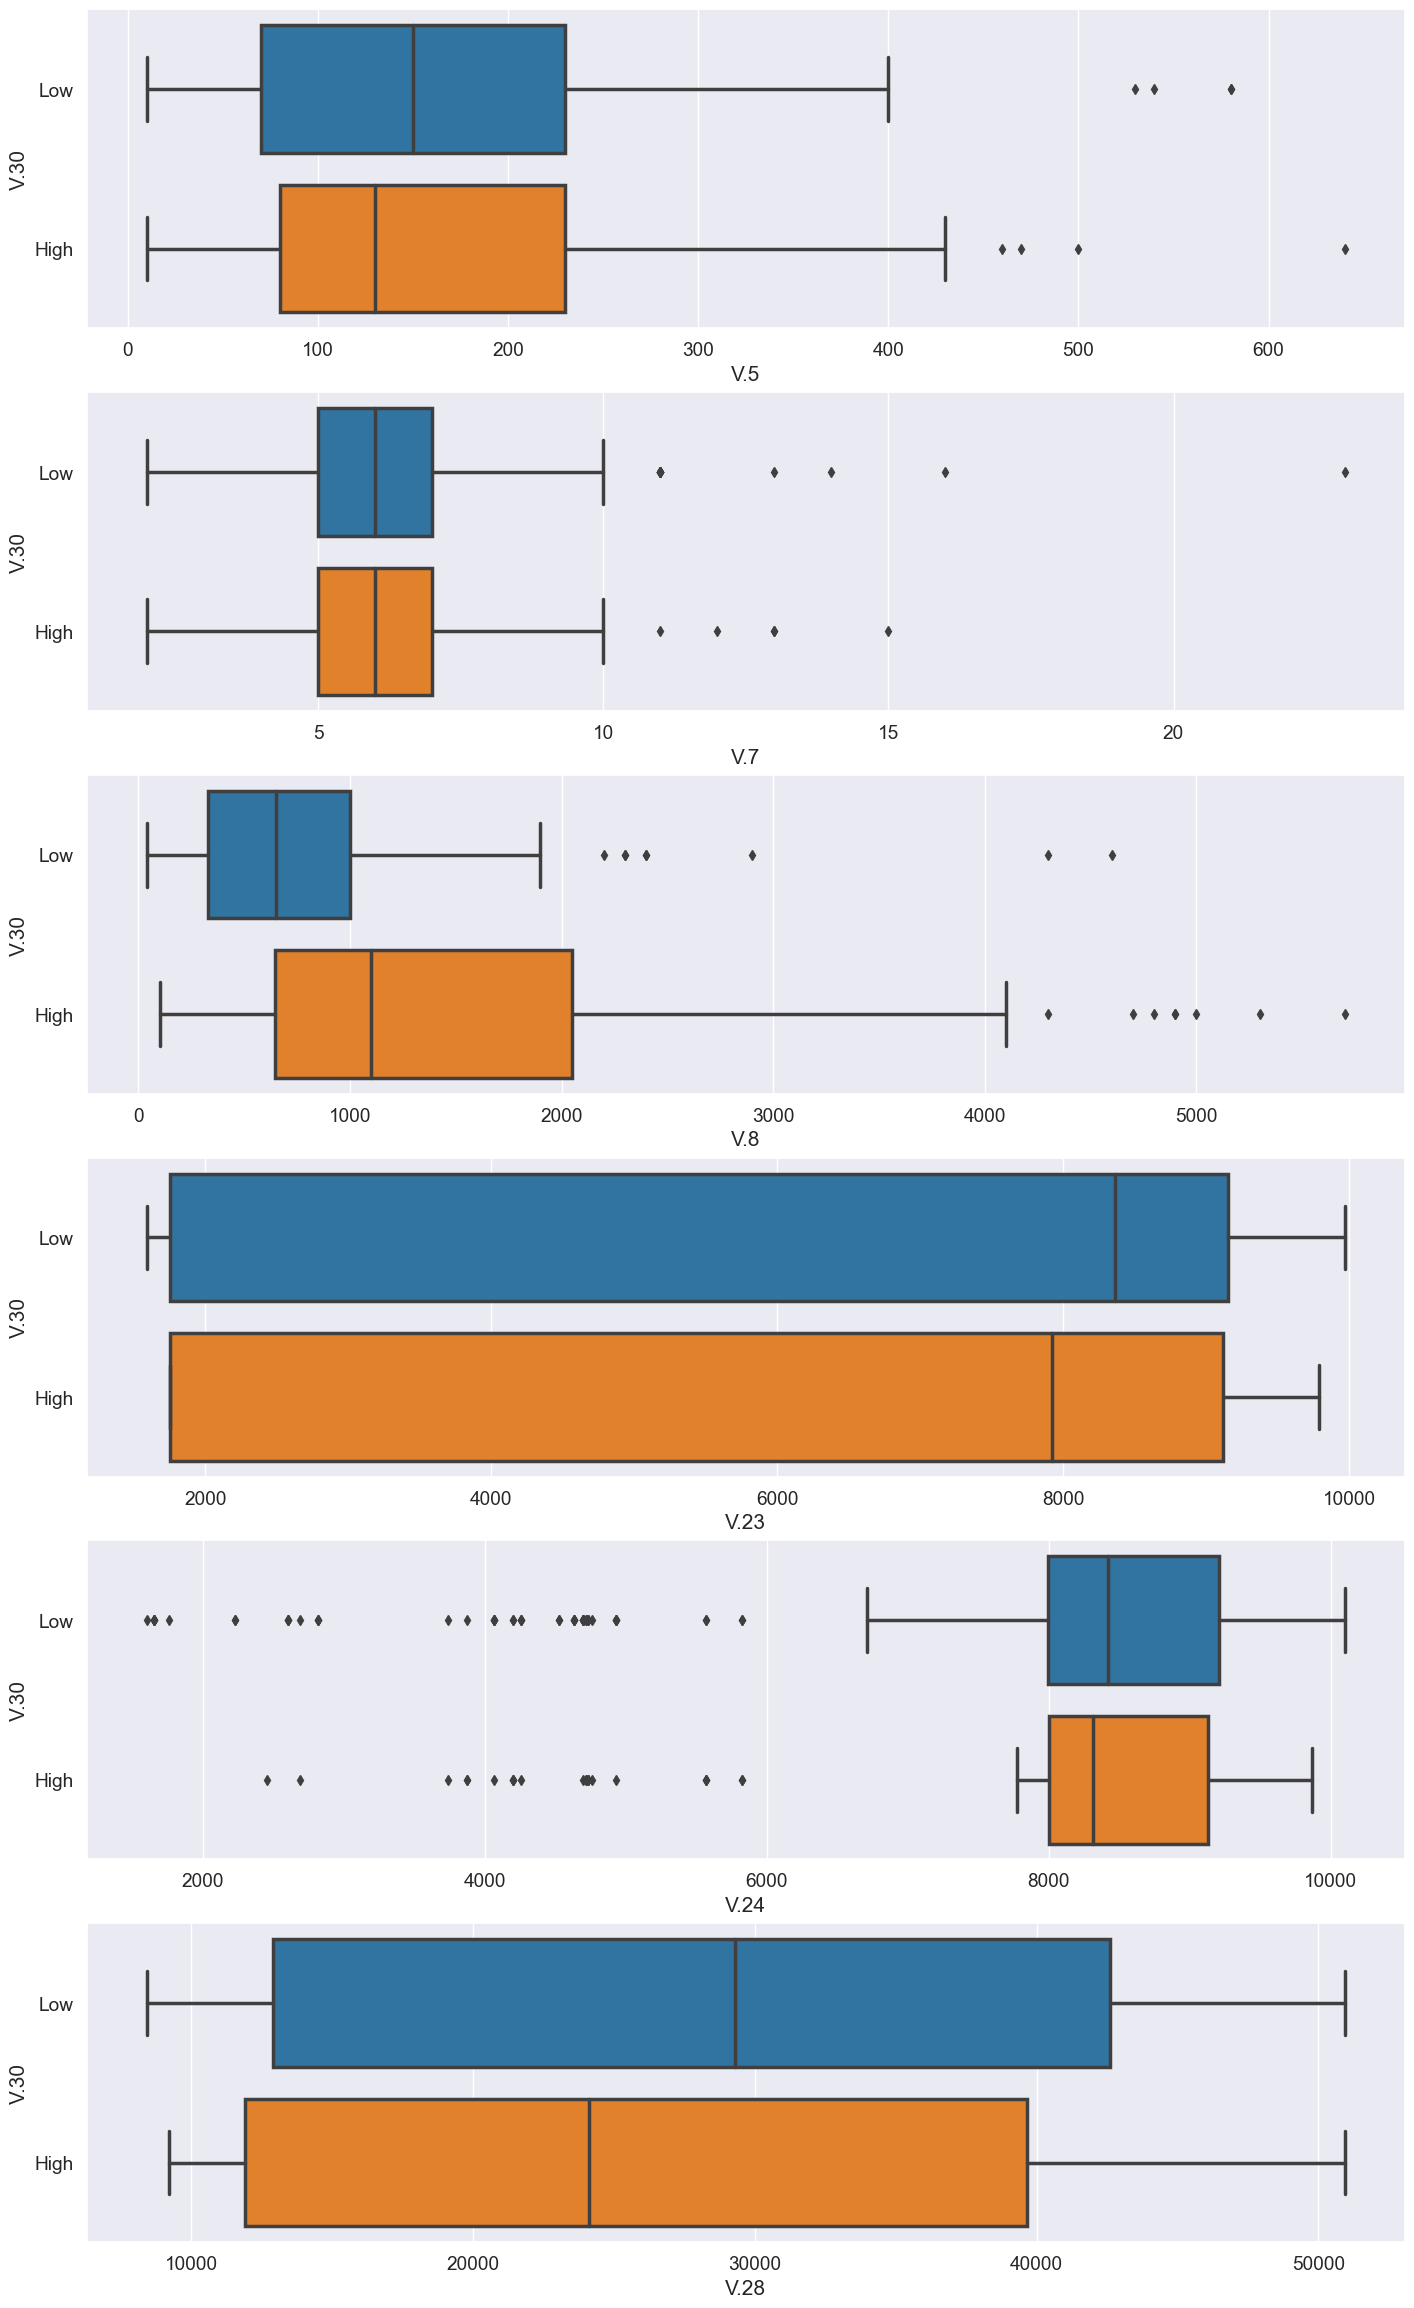

In [26]:
selected_cols = ['V.5','V.7','V.8','V.23','V.24','V.28']

fig2, axes = plt.subplots(len(selected_cols), 1, figsize=(17, 29))
df = pd.read_csv(csvfile)
map_dict = {1: "High", 0:"Low"}
df["V.30"] = df["V.30"].map(map_dict)
for idx, col in enumerate(selected_cols):
  if not col in ['V.30']:
    sns.boxplot(data=df, x=col,y='V.30', ax=axes[idx])

## As expected, we got 100% test accuracy. However, with a 5-fold CV score of 0.3768, this is likely a poorer (or less generalised) model compared to our feature-engineered model with a 5-fold CV score of 0.3551, even though its test accuracy is at 96% (3 wrong predictions). 

## Nevertheless, the features identified here give us a good clue on which features also important in identifying high margin projects

## Our brute-force method also found other sets (4 & 5) with test accuracy of 98.6%. Their 5-fold CV score are also worse than our feature engineered model.

4 features + categorical features, test accuracy: 0.9867 , 5-fold CV_RMSE_Score:0.3872


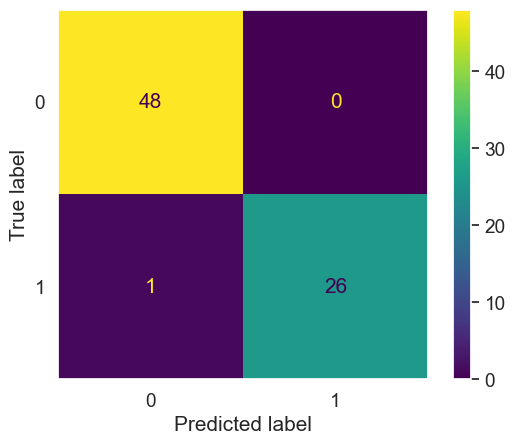

In [27]:
selected_cols = ['V.5', 'V.8', 'V.23', 'V.24']
    ## project variables
    # V-5	Preliminary estimated construction cost based on the prices at the beginning of the project
    # V-8	Price of the unit at the beginning of the project per m2
    ## economic variables
    # V-23	Official exchange rate with respect to dollars 
    # V-24	Nonofficial (street market) exchange rate with respect to dollars

log_reg = LogisticRegression()
train_x_Selected = train_x[selected_cols+oh_cols]
test_x_Selected = test_x[selected_cols+oh_cols]
scores = cross_val_score(log_reg, train_x_Selected, train_y2, cv=5, scoring='neg_root_mean_squared_error')
score = round(abs(stats.mean(scores)),4)
clf = log_reg.fit(train_x_Selected, train_y2)
print("4 features + categorical features, test accuracy: "\
      + str(round(clf.score(test_x_Selected, test_y2),4)), ", 5-fold CV_RMSE_Score:"  + str(score))
pred_y2 = clf.predict(test_x_Selected)
cm = confusion_matrix(test_y2, pred_y2, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(False)

5 features + categorical features, test accuracy: 0.9867 , 5-fold CV_RMSE_Score:0.4083


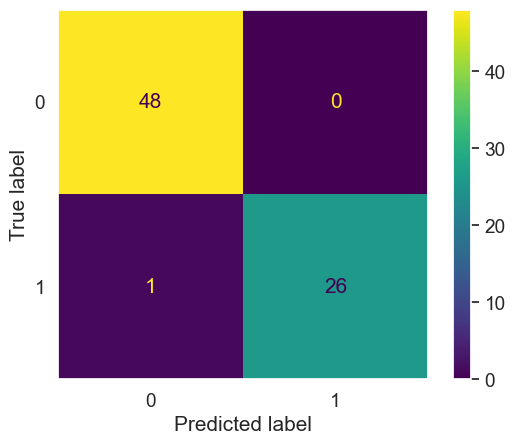

In [28]:
selected_cols = ['V.2', 'V.5', 'V.8', 'V.23', 'V.24']
    ## project variables
    # V-2	Total floor area of the building
    # V-5	Preliminary estimated construction cost based on the prices at the beginning of the project
    # V-8	Price of the unit at the beginning of the project per m2
    ## economic variables
    # V-23	Official exchange rate with respect to dollars 
    # V-24	Nonofficial (street market) exchange rate with respect to dollars
log_reg = LogisticRegression()
train_x_Selected = train_x[selected_cols+oh_cols]
test_x_Selected = test_x[selected_cols+oh_cols]
scores = cross_val_score(log_reg, train_x_Selected, train_y2, cv=5, scoring='neg_root_mean_squared_error')
score = round(abs(stats.mean(scores)),4)
clf = log_reg.fit(train_x_Selected, train_y2)
print("5 features + categorical features, test accuracy: "\
      + str(round(clf.score(test_x_Selected, test_y2),4)), ", 5-fold CV_RMSE_Score:"  + str(score))
pred_y2 = clf.predict(test_x_Selected)
cm = confusion_matrix(test_y2, pred_y2, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(False)